In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#Author: Antonio Alonso
#Date: 7/5/2022
#College: Virginia Tech '23
#Graduation: May 2023

In [4]:
#Import Packages
!pip install -q xlrd
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras import models
from keras.layers import Embedding, Dense, Flatten
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from numpy import asarray
from numpy import zeros
from keras.engine import input_layer
from keras.layers import Dot, Average, Input, Concatenate, Dropout, Add, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
import random
from tensorflow.keras import regularizers


In [5]:
#Constants
num_embed_features = 4
embed_file_cardinality = 100
DOWNSAMPLE_COLS = ["Retail Trade", "Entertainment", "Trade, Professional and Personal Services", "Health and Community Services"]
embed_file_name = '/content/drive/MyDrive/Wells_Fargo_Campus_Analytics_Challenge_2022/glove.6B.100d.txt'
training_file_name = '/content/drive/MyDrive/Wells_Fargo_Campus_Analytics_Challenge_2022/dbb4c4ff1f31-CAC+2022_Training+Data+Set+New.xlsx'
testing_file_name = '/content/drive/MyDrive/Wells_Fargo_Campus_Analytics_Challenge_2022/dbb4c4ff1f31-CAC+2022_Test+Data+Set+New.xlsx'


In [6]:
def load_data(name):
  #Load in Training Data
  if name is "train":
    df = pd.read_excel(training_file_name)
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    return train, test
  elif name is "test":
    df = pd.read_excel(testing_file_name)
  elif name is "all":
    df = pd.read_excel(training_file_name)
  else:
    raise Exception('Error type not accepted')
  return df

def remove_null(df):
  cols_with_nan = df.columns[df.isnull().any()]
  for col_name in cols_with_nan:
    col = df[col_name]
    if np.issubdtype(col.dtype, np.number):
      col = col.fillna(value = 0)
    else:
      col = col.fillna(value= "ukn")
    df[col_name] = col
  return df

def preprocessing(df):

  df_params = {}

  #Aquire Labels
  df_params["labels"] = df["Category"]

  df_params["classes"] = sorted(list(set(df_params["labels"])))


  #Remove "T" from trasaction number
  df["cdf_seq_no"] = df["cdf_seq_no"].str[1:]

  #Calculate number of unique values per column
  df_params["unqiue_values"] = df.nunique(axis=0)

  #Remove null values in df and fill
  df = remove_null(df)



  df_params["df"] = df

  return df_params

def normalize_dataset(df_params):

  UPSAMPLE_COLS = list(set(df_params["df"]["Category"]) - set(DOWNSAMPLE_COLS))

  #Downsample the Classes with lots of examples
  for val in DOWNSAMPLE_COLS:
    rows = list(df_params["df"].loc[(df_params["df"]['Category'] == val)].index[:])
    count_total = df_params["df"]['Category'].value_counts()[val]
    sampled_list = random.sample(rows, count_total - 3000)
    df_params["df"].drop(sampled_list, axis=0, inplace=True)

  #Aquire Labels
  df_params["labels"] = df_params["df"]["Category"]


  df_params["encoder"] = LabelEncoder().fit(df_params["labels"])
  df_params["encoded_Y"] = df_params["encoder"].transform(df_params["labels"])

  cols = df_params["df"].columns
  num_cols = df_params["df"]._get_numeric_data().columns
  cate_cols = list(set(cols) - set(num_cols))

  strategy = {}

  for index, _ in enumerate(set(df_params["df"]["Category"])):
    strategy[index] = 3000

  for col in df_params["df"].columns:
    if col in cate_cols:
      df_params["df"][col]= df_params["df"][col].astype(str)

  df_params["df"] = df_params["df"].drop("Category", axis=1)

  #Save Originial Columns
  df_params["originial_col_names"] = df_params["df"].columns.tolist()
  
  #Upsamples Classes with few examples
  smote_nc = SMOTENC(categorical_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12], sampling_strategy=strategy,  random_state=0)
  df_params["df"], df_params["encoded_Y"] = smote_nc.fit_resample(df_params["df"], df_params["encoded_Y"])

  df_params["target"] = np_utils.to_categorical(df_params["encoded_Y"])

  return df_params


def split_data_training(df_params):

  df_params_test = df_params.copy()

  df_params["df"], df_params_test["df"], df_params["labels"], df_params_test["labels"] = train_test_split(df_params["df"], df_params["labels"], test_size=0.30, random_state=42)
  return df_params, df_params_test

def feature_engineering(df_params):

  df = df_params["df"]

  #One Hot Encoder
  encoder = LabelEncoder()
  #Calculate Numerical, Categorical, and Binary Features
  embedding_cols = df.columns[df.nunique(axis=0) > 50]
  numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
  hashing_cols = ["cdf_seq_no"]
  embedding_cols = list(set(embedding_cols) - set(numeric_cols))
  embedding_cols.remove("cdf_seq_no")

  #Used for saving new features
  vectorized_features = []
  vectorized_hashing = []
  feature_vocab_size ={}
  feature_tokenizer = {}

  for col in df.columns:
    #New Feature Name
    processed_name = col + "Processed"

    #Embedding Categorical Feature Type
    if col in embedding_cols:

      #Tokenize and Map
      df[col] = df[col].astype(str)
      t = Tokenizer()
      t.fit_on_texts(df[col])
      vocab_size = len(t.word_index) + 1
      encoded_map = t.texts_to_sequences(df[col])

      #Pad and Trim Sequences
      max_length = 18 if len(encoded_map[0]) > 5 else 5
      padded_map = pad_sequences(encoded_map, maxlen=max_length, padding='post')

      #save tokenizer, vocab_size, and padded sequence
      vectorized_features.append(padded_map)
      feature_tokenizer[col] = t
      feature_vocab_size[col] = vocab_size

    #Numeric Feature Type
    elif col in numeric_cols:
      df[processed_name] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    #Hashing Vectorizer Feature Type (all_unique)
    elif col in hashing_cols:
      df[col] = df[col].astype(str)
      num_features = min(750, (df[col].nunique() + 1) / 2)
      vectorizer = HashingVectorizer(n_features = num_features)
      vector = vectorizer.fit_transform(df[col])
      temp2 = vector.toarray()
      vectorized_hashing.append(temp2)

    #One Hot Encoded Features
    else:
      encoder.fit(df[col])
      encoded_Y = encoder.transform(df[col])
      temp3 = np_utils.to_categorical(encoded_Y)

      #Create new column for each One Hot Encoded Feature
      for index in range(temp3.shape[1]):
        df[processed_name + "_" + str(index)]= temp3[:, index]
  
  df_params["df"] = df
  df_params["vectorized_features"] = vectorized_features
  df_params["vectorized_hashing"] = vectorized_hashing
  df_params["feature_vocab_size"] = feature_vocab_size
  df_params["feature_tokenizer"] = feature_tokenizer

  return df_params

#Function for Cleaning up data
def post_processing(df_params):

  #Remove originial Columns from df
  df_params["df"] = df_params["df"].drop(columns=df_params["originial_col_names"])
  df_params["strict"] = df_params["df"].to_numpy()
  return df_params

#Function that loads in Embedding File
def load_embed_file():
  embeddings_index = {}
  f = open(embed_file_name)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

#Function that Mapps tokenized words to feature matricies for the Embedding Layers
def generate_embedding_matrix(vocab_size, t, embeddings_index):
  embedding_matrix = zeros((vocab_size, embed_file_cardinality))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix

#Function that Maps tokenized words to feature matricies for the Embedding Layers for all features
def generate_feature_matricies(df_params):
  embeddings_index= df_params["embed_dict"]
  feature_matricies = {}
  for vocab_size, tokenizer in zip(df_params["feature_vocab_size"].values(), df_params["feature_tokenizer"].items()):
    feature_matricies[tokenizer[0]] = generate_embedding_matrix(vocab_size, tokenizer[1], embeddings_index)

  df_params["feature_matricies"] = feature_matricies

  return df_params

#Function that creates a single Embedding Layer with Pretrained Word Vectors
def create_embed(x, vocab, embedding_matrix , embedding_dim=100):
  embedding = Embedding(vocab, embedding_dim, weights=[embedding_matrix], input_length=x.shape[1], trainable=False)(x)
  return embedding

#Function that Generates Multiple Embedding Layers and then Applies Convolution and Pooling to each Tokenized Feature
def generate_embeddings(vectorized_sequences, vocab_list, embedding_matrix):
  output = []
  emb = [create_embed(embed, vocab=vocab_list[i], embedding_matrix=embedding_matrix[i]) for i, embed in enumerate(vectorized_sequences)]
  for index in range(num_embed_features):
    conv = Conv1D(128,3, activation='relu',
                                 kernel_regularizer = regularizers.l2(0.0005),
                                 bias_regularizer = regularizers.l2(0.0005))(emb[index])
    conv = GlobalMaxPooling1D()(conv)
    conv = Dropout(0.5)(conv)
    output.append(conv)
  return output

#Function to create Model and define Architecture and Inputs
def create_model(df_params):

  #Inputs to the Model
  strict_input = Input(shape=(df_params["strict"].shape[1], ), name="df")
  input_cdf_seq_no = Input(shape=(df_params["vectorized_hashing"][0].shape[1], ), name="cdf_seq_no")
  input_trans_desc = Input(shape=(df_params["vectorized_features"][0].shape[1], ), name="trans_desc")
  input_default_brand = Input(shape=(df_params["vectorized_features"][1].shape[1], ), name="default_brand")
  input_default_location = Input(shape= (df_params["vectorized_features"][2].shape[1], ), name="default_location")
  input_qrated_brand = Input(shape= (df_params["vectorized_features"][3].shape[1], ), name="qrated_brand")
  input_coalesced_brand = Input(shape=(df_params["vectorized_features"][4].shape[1], ), name="coalesced_brand")

  name_to_pop = "trans_desc"
  matrix = df_params["feature_matricies"].pop(name_to_pop)
  vocab_size = df_params["feature_vocab_size"].pop(name_to_pop)


  embed_matrix = list(df_params["feature_matricies"].values())
  vocab_list = list(df_params["feature_vocab_size"].values())
  
  #Hashing Feature input Functionality
  trans_desc_embed = create_embed(input_trans_desc, vocab_size, matrix)
  trans_desc_flattened = Flatten()(trans_desc_embed)
  trans_desc_layer = Dense(512, activation='relu')(trans_desc_flattened)
  trans_desc_layer = Dense(128, activation='relu')(trans_desc_layer) 
  trans_desc_layer = Dropout(0.3)(trans_desc_layer)

  #Generates Embeddings for Feature inputs
  output = generate_embeddings([input_default_brand, input_default_location, input_qrated_brand, input_coalesced_brand], vocab_list, embed_matrix)

  stacked = Concatenate()([output[0], output[1], output[2], output[3]])
  
  embed_concat = Dense(128, activation='linear')(stacked)
  embed_concat = Dropout(0.3)(embed_concat)

  #Combine Descrption Input with Embedding Represetations
  concat = Concatenate()([embed_concat, trans_desc_layer])

  x = Dense(256, activation="relu")(strict_input)
  #Dropout layer to reduce overfitting
  x = Dropout(0.5)(x)
  x = Dense(128, activation="relu")(x)


  y = Dense(256, activation="relu")(input_cdf_seq_no)
  #Dropout layer to reduce overfitting
  y = Dropout(0.5)(y)
  y = Dense(128, activation="relu")(y)

  final = Concatenate()([concat, x])
  final = Concatenate()([final, y])
  final = Dropout(0.3)(final)

  x1 = Dense(256, activation='softmax')(final)
  x2 = Dense(128, activation='relu', kernel_initializer="uniform")(x1)
  x3 = Dense(32, activation='relu', kernel_initializer="uniform")(x2)
  #Classification Layer for 10 distinct Classes
  out = Dense(10, activation='sigmoid', kernel_initializer="uniform", name="target")(x3)

  model = Model(inputs=[strict_input, input_cdf_seq_no, input_trans_desc, input_default_brand, input_default_location, input_qrated_brand, input_coalesced_brand], outputs = out)
  model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

  df_params["model"] = model

  return df_params


In [7]:
#Function to Train Model with Various Inputs
def train_model(df_params):

  df_params["history"] = df_params["model"].fit({"df": df_params["strict"],
                     "cdf_seq_no":      df_params["vectorized_hashing"][0],
                     "trans_desc":      df_params["vectorized_features"][0],
                     "default_brand":   df_params["vectorized_features"][1],
                     "default_location":df_params["vectorized_features"][2],
                     "qrated_brand":    df_params["vectorized_features"][3],
                     "coalesced_brand": df_params["vectorized_features"][4]},
                     {"target": df_params["target"]}, validation_split = 0.3, epochs=75, batch_size=512)
  return df_params

#Function to Generate New Labels from Trained Model
def model_predict(df_params, df_test_params):
  df_params["label_probabilities"] = df_params["model"].predict(
      {"df": df_test_params["strict"],
       "cdf_seq_no":      df_test_params["vectorized_hashing"][0],
       "trans_desc":      df_test_params["vectorized_features"][0],
       "default_brand":   df_test_params["vectorized_features"][1],
       "default_location":df_test_params["vectorized_features"][2],
       "qrated_brand":    df_test_params["vectorized_features"][3],
       "coalesced_brand": df_test_params["vectorized_features"][4]})
  df_params["predictions"] = np.argmax(df_params["label_probabilities"], axis=1)
  df_params["Test Labels"] = df_params["encoder"].inverse_transform(df_params["predictions"])
  return df_params

#Function to evaluate model on Testing Split
def evaluate_model(df_params, df_test_params):
  df_params["model_eval"]=df_params["model"].evaluate({
       "df": df_test_params["strict"],
       "cdf_seq_no":      df_test_params["vectorized_hashing"][0],
       "trans_desc":      df_test_params["vectorized_features"][0],
       "default_brand":   df_test_params["vectorized_features"][1],
       "default_location":df_test_params["vectorized_features"][2],
       "qrated_brand":    df_test_params["vectorized_features"][3],
       "coalesced_brand": df_test_params["vectorized_features"][4]}, df_test_params["target"], verbose=2)
  print('Test loss:', df_params["model_eval"][0], 'Test accuracy:', df_params["model_eval"][1])

  df_params["label_probabilities"] = df_params["model"].predict(
      {"df": df_test_params["strict"],
       "cdf_seq_no":      df_test_params["vectorized_hashing"][0],
       "trans_desc":      df_test_params["vectorized_features"][0],
       "default_brand":   df_test_params["vectorized_features"][1],
       "default_location":df_test_params["vectorized_features"][2],
       "qrated_brand":    df_test_params["vectorized_features"][3],
       "coalesced_brand": df_test_params["vectorized_features"][4]})
  df_params["predictions"] = np.argmax(df_params["label_probabilities"], axis = 1)
  return df_params

#Function for visualizing Training Accuracy and Loss over Epochs
def visualize_performance(df_params):
  plt.plot(df_params["history"].history['accuracy'])
  plt.plot(df_params["history"].history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()
  plt.plot(df_params["history"].history['loss'])
  plt.plot(df_params["history"].history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()
  df_params["plt"] = plt
  return df_params



In [ ]:
# Function Definitions and Functionality

# load_data: Loads in Train and Testing Data
# remove_null: Data Cleaning
# preprocessing: Data Cleaning
# feature_engineering: Tokenization, Hashing, One-Hot-Encoding
# post_processing: Finalizing Dataframe & Fixing Data types
# load_embed_file: GloVe: Global Vectors for Word Representation Pretrained Word Embeddings
# generate_embedding_matrix: Maps Word-Embeddings to Sequences
# generate_feature_matricies: Wrapper
# create_embed: Creates Embedding Layer
# generate_embeddings: Between Multiple Embeddings

#This is the training flow for Strictly Data Prep
def data_prep_flow(data=None):

  if data is None:
    df = load_data("test")
  else:
    df = data
  
  #Section A
  df = preprocessing(df)
  
  #Section B
  df["labels"] = df["df"]["Category"]
  df["df"] = df["df"].drop("Category", axis=1)
  df["originial_col_names"] = df["df"].columns.tolist()
  df["encoder"] = LabelEncoder().fit(df["labels"])
  df["encoded_Y"] = df["encoder"].transform(df["labels"])
  df["target"] = np_utils.to_categorical(df["encoded_Y"])

  #Section C
  df = feature_engineering(df)
  #Section D
  df = post_processing(df)

  return df

#This is the Training Pipeline for Data Generation and Model Training
def flow_train(embed_dict):

  #Section A
  df, df_test = load_data("train")

  #Section B
  df = preprocessing(df)

  #Section B
  df = normalize_dataset(df)

  #Section C
  df = feature_engineering(df)

  #Section D
  df = post_processing(df)

  df["embed_dict"] = embed_dict

  #Section E
  df = generate_feature_matricies(df)

  #Section E
  df = create_model(df)

  #Section E
  df = train_model(df)

  #Section E
  df = visualize_performance(df)

  return df, df_test

def main():

  #Section A Loading in Word Embeddings
  word_embedding_dict = load_embed_file()

  #Section A-G, Generating training data and Model
  df_train, df_train_test = flow_train(word_embedding_dict)

  #Section A-D, Generating testing split of training data
  df_train_test = data_prep_flow(df_train_test)

  #Section A-D, Generating Testing Data
  df_test = data_prep_flow()

  #Section E, Model evaluation on testing split
  df_train_test = evaluate_model(df_train, df_train_test)
  
  #Section F, Generating New Labels
  df = model_predict(df_train, df_test)

  return df
  

df = main()

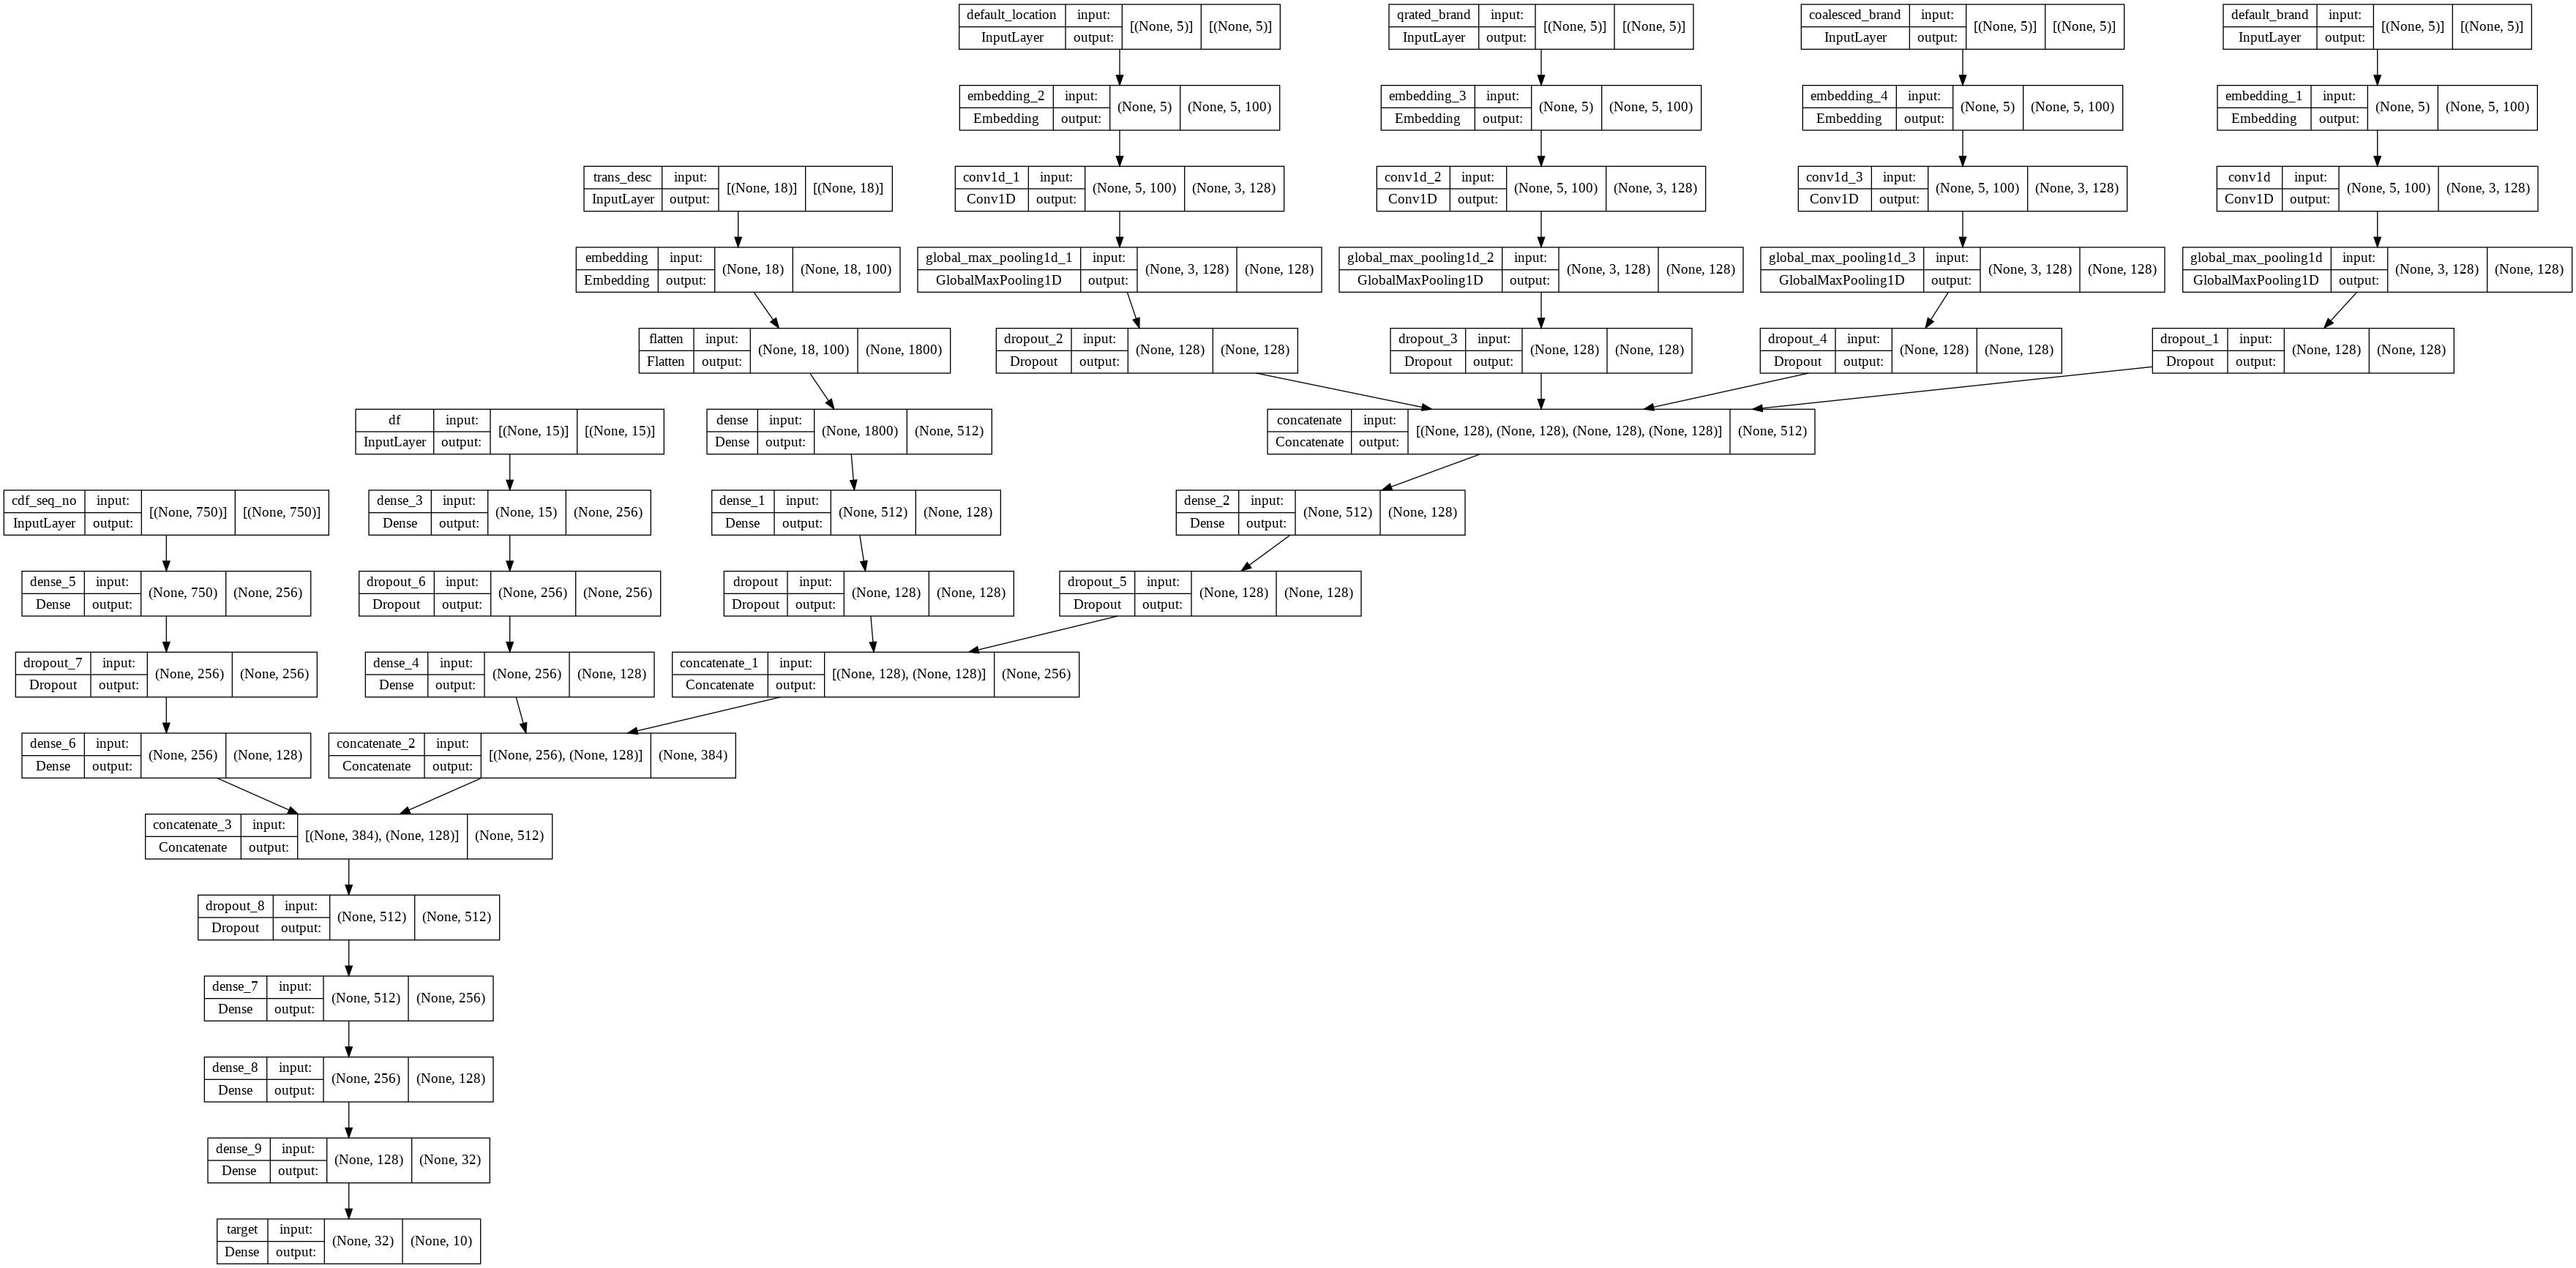

In [9]:
tf.keras.utils.plot_model(df["model"], "multi_input_and_output_model.png", show_shapes=True)

In [14]:
from numpy import savetxt

np.savetxt('data.txt',  df["Test Labels"], fmt='%s')